In [16]:
import smrf
import numpy as np
#from laspy.file import File
import laspy

import matplotlib.pyplot as plt

import rasterio

In [4]:
fn = r"data/DK22_partial.las"
#inFile = File(fn)
las = laspy.read(fn)

Laspy returns an object that you can use to access the portions you need.  However, accessing the xyz data directly doesn't always work, as you will receive a ScaledArrayView that may not work in every application, including smrf:

In [7]:
las.x

<ScaledArrayView([865089.74998779 865089.74998779 865094.83998779 ... 868165.81998779
 868169.55998779 868169.59998779])>

However, if you wrap this in a standard numpy.array() call, you can re-organize it.

In [10]:
np.array(las.x)

array([865089.74998779, 865089.74998779, 865094.83998779, ...,
       868165.81998779, 868169.55998779, 868169.59998779])

In [20]:
# We'll do that, but with a condensed call that is faster than doing all three (xyz) separately:
# Note: this is an ancient LAS file, and is in FEET!  Hence the "large" cellsize.

Z,T,obj_cells,obj_array = smrf.smrf(*np.array((las.x,las.y,las.z)),cellsize=5,windows=7,
                                                slope_threshold=.15,elevation_threshold=.5,elevation_scaler=1.25,
                                                low_filter_slope=5,low_outlier_fill=False)

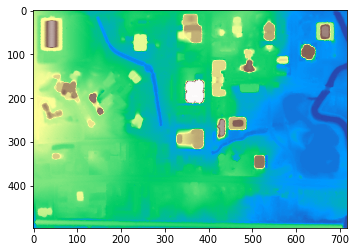

In [14]:
plt.imshow(Z,cmap='terrain')

In [18]:
# Write out smrf'ed DTM

with rasterio.open('out.tif', 'w', driver='GTiff', 
                             height=Z.shape[0], width=Z.shape[1],
                             count=1, dtype=np.float32, transform=T) as src:
    src.write(Z.astype(np.float32), 1)

In [21]:
# We'll use the header from the original to save trouble, copy over the x,y,z coords and add the SMRFed 
# ground point classification. (SMRF returns a boolean vector of object points, so a little math to convert 
# to ASPRS standard 2-is-ground format.)

# Note: We are OVERWRITING the classification with this.  This may not be what you want to do!
las.classification[obj_array==0] = 2
las.classification[obj_array==1] = 1
#%% Export classified point cloud
new_file = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
new_file.points = las.points
new_file.classification[obj_array==0] = 2
new_file.write('DK22_partial.classified.las')